## Code examples for "Statistical methods to distinguish impacts from shallow moonquakes" Turner et al. 2024

This is a simple tutorial to demonstrate the data processing and statistical methods applied to the Apollo lunar seismic data. These statistical methods provide quantitative metrics to distinguish the seismic signals of shallow moonquakes from those of impacts. 

The notebook is set up into two parts:
1. Data processing for K-L divergence comparison of shallow moonquakes and impacts. 
2. Application of tsfresh to Apollo seismic data.

For more details, please see Turner et al. (2024).

<em> NOTE: for ease of this notebook, the data is downloaded from IRIS, not the version of the data downloaded from IPGP http://datacenter.ipgp.fr/. There are slight differences in the pre-processing that has been used for these two different datasets, which changes the amplitude of some of the high frequency data. However, this only acts to make the impacts and shallow moonquake spectra more different, and therefore does not effect the results presented in this paper. </em>

## Getting set up

The data processing for both parts 1 and 2 of this notebook is dependant on [obspy](https://docs.obspy.org/), and some specialized functions included in the file [moonquake_functions.py](./moonquake_functions.py) within this tutorial file. The statistical tests are dependant on the [tensorflow (for the K-L divergence)](https://www.tensorflow.org/), [scipy statistical functions](https://docs.scipy.org/doc/scipy/reference/stats.html), and [tsfresh](https://tsfresh.readthedocs.io/en/latest/). 

These packages can be easily and quickly installed in a conda enviroment with the provided with the included .yml file. 


```python:

conda env create -f shallow_mq_stats.yml

```


In [1]:
#adding this tutorial dir to python path
import sys
sys.path.append('/home/utig5/alice/Documents/Apollo/shallow_moonquake_SAC/lib/identifying_events/code_example')


#installing required packages
import obspy 
from obspy.core.utcdatetime import UTCDateTime
from obspy.clients.fdsn.client import Client
import scipy 
import scipy.stats
from Moonquake_functions import *
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from obspy.signal.trigger import recursive_sta_lta, plot_trigger
from tsfresh.feature_extraction import EfficientFCParameters,MinimalFCParameters
settings = EfficientFCParameters()
from tsfresh import extract_features
from tsfresh.feature_selection import significance_tests
#downloading data from IRIS 
client = Client("IRIS")
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import textwrap 

2024-06-14 13:53:14.317487: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Example data 

In this tutorial, I use the two high quality waveforms:
1. A shallow moonquake recorded at station S15 at 0801 am on March 13, 1973.
2. An impact recorded at station S15 at 0045 am on August 13, 1975.

The start, end, and event types for these signals are taken from the [Nakamura Apollo seismic event catalog](https://repositories.lib.utexas.edu/items/3c162b9a-ce04-4900-8f6e-63147eb7d4db).These are the same events that are plotted in Figure 1 of Turner et al. (2024). 

In [ ]:
#downloading data from IRIS 
client = Client("IRIS")

#Apollo seismic network 
net = "XA"  # network of the station
sta = "S15"  # station code
loc = "*"  # any loc code
chan = "SHZ" #short period vertical

################ downloading the data from the shallow moonquake ################ 

starttime = UTCDateTime('1973-072T08:01') #example shallow moonquake start-time taken 
#starttime= UTCDateTime('1973-039T22:53')
endtime = starttime+2000

#waveform data 
shallowMQ = client.get_waveforms(net, sta, loc, chan, starttime, endtime)

#instrument response 
invSMQ = client.get_stations(starttime=starttime, endtime=endtime,
                     network=net, sta=sta, loc='*', channel=chan,
                     level="response")


################ downloading the data from the impact ################ 

starttime = UTCDateTime('1975-225T00:54')
#starttime= UTCDateTime('1977-256T11:37')
endtime = starttime+2000 

Impact= client.get_waveforms(net, sta, loc, chan, starttime, endtime)

#instrument response 
invIMP = client.get_stations(starttime=starttime, endtime=endtime,
                     network=net, sta=sta, loc='*', channel=chan,
                     level="response")


## 1a. Data processing  and plotting for K-L divergence comparison 

Each shallow moonquake (H) and impact (C) in the catalogue is windowed for 2000 seconds after the start time reported in the catalogue. The signals are despiked using a median filter, and any gaps are filled in with a linear interpolation.  The raw data is converted to acceleration waveforms with a pre-filter of 1- 13 Hz.

For each of the events in the dataset, we then calculate the frequency spectrum in each time period using the built-in obspy spectrogram function with the default 128 sample window length. The final step is then to normalise the spectra so that they sum to 1 and can be considered a probability distribution. To do this, we first apply a binary mask to the amplitude of the frequency spectra, and we keep only points that are larger than 20\% of the maximum amplitude of each event, creating a density plot. From this density plot, we then calculate a probability using a kernel density estimate. The kernel density estimate is calculated using the sklearn.neighbors.KernelDensity python function with a bandwidth of 1 and the default gaussian Kernel. The kernel density estimate is then smoothed using a Gaussian filter with a sigma of 5. 

In [ ]:
###########################SET UP AXIS FOR FIGURE####################################
rows, cols = 3, 2
fig, AX = plt.subplots(rows, cols,sharex='col',sharey='row')

###########################MOONQUAKE PREPROCESSING AND FILTERING ####################################
tr = shallowMQ[0]
original_mask = linear_interpolation(tr,interpolation_limit=None)
tr.data = tr.data - np.mean(tr.data)
dat = despike_step2(tr.data,5,961) #despike
tr.data = dat[0]
#tr.data = np.ma.masked_array(tr, mask=original_mask) #interpolate, getting rid of gaps that were filled with -1 
pre_filt = [1,2,11,13]
tr.remove_response(inventory=invSMQ, pre_filt=pre_filt, output="VEL", 
                        water_level=None, plot=False)  #remove instrument response, convert counts to acceletration waveform
tr.filter("bandpass", freqmin=1, freqmax=13, corners=2, zerophase=True) #bandpass filter

###########################PLOTTING MOONQUAKE TIMESERIES####################################
mq_waveform_amp=tr.data #pulling out the acceleration amplitude data 
mq_waveform_time=np.arange(0,tr.stats.npts)/tr.stats.sampling_rate #time axis
AX[0,0].plot(mq_waveform_time,mq_waveform_amp)
AX[0,0].set_xlim([0,1690])
AX[0,0].set_ylabel('Acceleration ($m/s^{2})$')

AX[0,0].text(-0.05, 1.15, 'A', transform=AX[0,0].transAxes,
      fontsize=12, fontweight='bold', va='top', ha='right')

###########################PROCESSING FOR MOONQUAKE SPECTROGRAM ####################################


specgram,time,freq = spectrogram_a(tr.data,46.375,log=False, title='test ' + str(tr.stats.starttime),wlen=2.7601078167115904)

        
down_sampled_specgram=specgram[0::5,0::5] #down sample by a factor of 5 
down_sampled_time=time[0::5]
down_sampled_freq=freq[0::5]

###########################PLOTTING FOR MOONQUAKE SPECTROGRAM ####################################

AX[1,0].pcolormesh(down_sampled_time,down_sampled_freq[46:]-11,np.flipud(down_sampled_specgram[46:,:]))
AX[1,0].set_ylabel('Frequency (Hz)')
AX[1,0].text(-0.05, 1.15, 'B', transform=AX[1,0].transAxes,
      fontsize=12, fontweight='bold', va='top', ha='right')


###########################PROCESSING FOR MOONQUAKE PROBABILITY ####################################
xa = []
ya = [] 
for t,x in enumerate(down_sampled_time):
    for f,y in enumerate(down_sampled_freq[46:]):
        if down_sampled_specgram[46:,:][f,t]> 0.2*np.max(down_sampled_specgram[46:,:]): #mask only taking point with amplitude above 20%
            xa.append(x)
            ya.append(y)
            
xa.append(down_sampled_time[0])
ya.append(down_sampled_freq[46:][0])
xa.append(down_sampled_time[-1])
ya.append(down_sampled_freq[46:][-1])

#KDE of the masked scatter plot. 
xx, yy, zz = kde2D(np.array(xa), np.array(ya), 1.0,xbins=511j, ybins=511j)
#gaussian filter
MOONQUAKE_PROB = scipy.ndimage.gaussian_filter(zz,5.0)

###########################PLOTTING FOR MOONQUAKE PROBABILITY ####################################
AX[2,0].pcolormesh(xx, yy-11, np.fliplr(MOONQUAKE_PROB))
AX[2,0].set_ylabel('Frequency (Hz)')
AX[2,0].set_xlabel('Time (s)')
AX[2,0].text(-0.05, 1.15, 'C', transform=AX[2,0].transAxes,
      fontsize=12, fontweight='bold', va='top', ha='right')

###########################IMPACT PREPROCESSING AND FILTERING ####################################

tr = Impact[0]
original_mask = linear_interpolation(tr,interpolation_limit=None)
tr.data = tr.data - np.mean(tr.data)
dat = despike_step2(tr.data,5,961) #despike
tr.data = dat[0]
#tr.data = np.ma.masked_array(tr, mask=original_mask) #interpolate, getting rid of gaps that were filled with -1 
pre_filt = [1,2,11,13]
tr.remove_response(inventory=invIMP, pre_filt=pre_filt, output="VEL",
                       water_level=None, plot=False) 
tr.filter("bandpass", freqmin=0.25, freqmax=20, corners=2, zerophase=True)
tr.resample(46.375)

###########################IMPACT TIMESERIES####################################
mq_waveform_amp=tr.data
mq_waveform_time=np.arange(0,tr.stats.npts)/tr.stats.sampling_rate
AX[0,1].plot(mq_waveform_time[:-2],mq_waveform_amp[:-2])
AX[0,1].set_xlim([0,1690])
AX[0,1].text(-0.05, 1.15, 'D', transform=AX[0,1].transAxes,
      fontsize=12, fontweight='bold', va='top', ha='right')

###########################PROCESSING FOR IMPACT SPECTROGRAM ####################################
specgram,time,freq = spectrogram_a(tr.data,46.375,log=False, title='test ' + str(tr.stats.starttime),wlen=2.7601078167115904)

     
down_sampled_specgram=specgram[0::5,0::5]
down_sampled_time=time[0::5]
down_sampled_freq=freq[0::5]

###########################PLOTTING FOR MOONQUAKE SPECTROGRAM ####################################

AX[1,1].pcolormesh(down_sampled_time,down_sampled_freq[46:]-11,np.flipud(down_sampled_specgram[46:,:]))
AX[1,1].text(-0.05, 1.15, 'E', transform=AX[1,1].transAxes,
      fontsize=12, fontweight='bold', va='top', ha='right')

###########################PROCESSING FOR IMPACT PROBABILITY ####################################
xa = []
ya = [] 


for t,x in enumerate(down_sampled_time):
    for f,y in enumerate(down_sampled_freq[46:]):
        if down_sampled_specgram[46:,:][f,t]> 0.2*np.max(down_sampled_specgram[46:,:]):
            xa.append(x)
            ya.append(y)
            
xa.append(down_sampled_time[0])
ya.append(down_sampled_freq[46:][0])
xa.append(down_sampled_time[-1])
ya.append(down_sampled_freq[46:][-1])


xx, yy, zz = kde2D(np.array(xa), np.array(ya), 1.0,xbins=511j, ybins=511j)
IMPACT_PROB = scipy.ndimage.gaussian_filter(zz,5.0)
###########################PLOTTING FOR IMPACT PROBABILITY ####################################
AX[2,1].pcolormesh(xx, yy-11, np.fliplr(IMPACT_PROB))
AX[2,1].set_xlabel('Time (s)')
AX[2,1].text(-0.05, 1.15, 'F', transform=AX[2,1].transAxes,
      fontsize=12, fontweight='bold', va='top', ha='right')


AX[0,1].set_title('Impact - August 13, 1975',y=1.2)
AX[0,0].set_title('Shallow moonquake - March 13, 1973',y=1.2)

plt.tight_layout()



## 1b. K-L divergence comparison 

Having created kernel density estimates of the event spectrograms, we can now  compare pairs of  the shallow moonquakes and impacts using the  Kullback-Leibler divergence (K-L) divergence. The Kullback-Leibler divergence is a measure of the dissimilarity between two probability distributions and is commonly used in machine learning and data science applications. Mathematically, the K-L divergence between the probability distribution of a reference shallow moonquake P(x) and the probability distribution of the signal that we wish to categorise Q(x) is given by: 

\begin{equation}
 K-L(P || Q) = \sum P(x) \frac{\log(P(x))}{Q(x)}.
\end{equation}

 The K-L divergence is always greater than or equal to zero;  a K-L divergence of 0 shows an identical pair of signals, while a large K-L divergence shows very different signals.  Intuitively, we expect shallow moonquakes to be similar to other shallow moonquakes and thus have a K-L divergence close to 0. Impacts will be dissimilar to shallow moonquakes and have a higher K-L divergence. It is important to note that the K-L divergence is not symmetrical; swapping P and Q, i.e. using the impact as the baseline to compare to instead of shallow moonquakes, would lead to different results. In this study, we are always comparing to shallow moonquakes. For each signal that we wish to categorise, we compare to all of the catalogued shallow moonquakes, and and summarise the results using the mean of all reference shallow moonquakes.

In [ ]:
y_true= 1*MOONQUAKE_PROB/np.nansum(MOONQUAKE_PROB) #Normalize
y_pred= 1*IMPACT_PROB/np.nansum(IMPACT_PROB) #Normalize
loss = tf.keras.losses.kullback_leibler_divergence(y_true, y_pred) #K-L 
result =np.nansum(loss) #reduction sum of all non-nan elements

print('The K-L divergence between the shallow moonquake and impact is '+str(result))

The dataset contains only a few shallow moonquakes that we can compare to. We supplement our distribution using a bootstrapping approach.  In each of the 1,000 bootstrap iterations for a signal that we wish to compare to (Q(x)), we randomly resample the shallow moonquakes in the catalogue with replacement and recalculate the K-L divergence and the mean K-L divergence for each event. This is run using multiprocessing and an example is not shown here. 

## 2a. Data and processing for tsfresh analysis

Tsfresh is a Python library used  to extract and select time series features \citep{christ2018time} . The package can quickly extract and explore almost 800 different time series features and assess their statistical significance for predicting the target. In our application, we calculate a total of 794 features for the sets of waveforms recorded at stations S15 and S16. Using a Kolmogorov–Smirnov test, a non-parametric test for comparing two distributions, we can identify features that have a 99\% probability of being drawn from different distributions; the features have a p-value of less than 0.01.  Finally, we visually analyze these distributions to identify characteristics that could help us differentiate shallow moonquakes from impacts.

We apply this to a dataset of shallow moonquakes and impacts which can be found in the text file included -- which includes the date and event ty he data processing steps are very similar to those described in section 2.1 and used in the K-L divergence analysis. The same despiking steps are taken, but a key difference is that the raw data is converted to displacement waveforms with a pre-filter of 1- 13 Hz instead of acceleration waveforms. The waveforms are then used in the statistical algorithms of tsfresh without further processing.

The input format for the tsfresh algorithm is a pandas.DataFrame with 3 columns: id -- the date of the event, the time of the timeseries and x, the amplitude of the timeseries. The waveforms are stacked to create one large dataframe of all of the events. Please see the tsfresh documentation for more details. 


In [ ]:
##########READING IN ALL OF THE S15 EVENTS USED IN THIS STUDY ##############
#downloading data from IRIS 
client = Client("IRIS")

#Apollo seismic network 
net = "XA"  # network of the station
sta = "S15"  # station code
loc = "*"  # any loc code
chan = "SHZ" #short period vertical

st3=obspy.Stream() #initalize obspy stream

i = 0

data = [] #initalize arrays that are needed to convert to the format needed for tsfresh
ids = []
time = []
EVENT_TYPE = [] 

f = open("S15_events.txt","r")
for line in f.readlines():
     print(line)
    #read event info from file
     starttime = (UTCDateTime(line.split(',')[0]))
     endtime = starttime + 2000
     event_type = line.split(',')[1]
     #load waveform and instrument response 
     st = client.get_waveforms(net, sta, loc, chan, starttime, endtime)
     inv = client.get_stations(starttime=starttime, endtime=endtime,
                     network=net, sta=sta, loc='*', channel=chan,
                     level="response")
    # #processing -- same as above
     tr = st[0]
     original_mask = linear_interpolation(tr,interpolation_limit=None)
     tr.data = tr.data - np.mean(tr.data)
     dat = despike_step2(tr.data.data,7,91) #despike
     tr.data = dat[0]
     pre_filt = [1,2,11,13]
     tr.remove_response(inventory=inv, pre_filt=pre_filt, output="VEL",
                       water_level=None, plot=False) 
     tr.filter("bandpass", freqmin=0.25, freqmax=20, corners=2, zerophase=True)
     tr.normalize()
     stav = 5
     ltav = 20
     cft = recursive_sta_lta(tr.data, int(stav * tr.stats.sampling_rate),
                           int(ltav * tr.stats.sampling_rate))
     if np.max(cft) < 1 or np.max(cft) > 5 :
        print(np.max(cft))
        tr.plot()
        print('does not pass quality check')
        continue
     if np.isnan(tr.data).all():
        continue
     st3+=tr #store all events in a single stream 

     data.append((tr.data))
     ids.append((np.full((tr.stats.npts),tr.stats.starttime)))
     time.append((np.arange(0,tr.stats.npts)*tr.stats.delta))
     EVENT_TYPE.append(event_type.strip())
     i = i+1

g = np.vstack((np.concatenate(ids, axis=0 ), np.concatenate(time, axis=0), np.concatenate(data, axis=0))).T #stacking the data into the right format

df = pd.DataFrame(g, columns = ['id','time','x']) #converting to a pandas dataframe

df.to_csv('S15_tsfresh_format.csv')


In [ ]:
st3

## extracting features using tsfresh 

Fueatures are extracted using the efficient paramiters dictionary. Please see tsfresh documentation for more details 

In [ ]:
#extracting features
df = pd.read_csv('S15_tsfresh_format.csv')
df.drop('Unnamed: 0', inplace=True, axis=1)
extracted_features = extract_features(df, column_id="id", column_sort="time",n_jobs=0,default_fc_parameters=settings)
extracted_features.to_csv('extracted_features_test.csv')

In [ ]:
df = pd.read_csv('S15_tsfresh_format.csv')
df.drop('Unnamed: 0', inplace=True, axis=1)

df.shape

In [ ]:
extracted_features = pd.read_csv('extracted_features_test.csv')

extracted_features

In [ ]:
#which features are significant?

#adding the event type to the extracted features database
binary_classification = np.zeros(len(extracted_features))
for idx,item in enumerate(EVENT_TYPE):
    if item =='C':
        binary_classification[idx]=1
extracted_features['binary_classification']=binary_classification
extracted_features['event_type']=EVENT_TYPE

df = extracted_features

df.iloc[:,1:-2] = df.iloc[:,1:-2].apply(lambda x: (x-x.mean())/ x.std(), axis=0)

pvals = np.ones(shape=len(df.columns))
for idx,col in enumerate(list(df.columns[1:-2])): 
    df4 = df[[col,'event_type','binary_classification']]
    if not np.array(df4[col].any()):
        continue 
    #smir test for significance for each event
    pvals[idx] = significance_tests.target_binary_feature_real_test(x=df4[col], y=df4['binary_classification'],test='smir')   
    
#mask events that are not significant to 99%
a = np.ma.masked_greater(pvals,0.01)
significant_features = df.loc[:,~a.mask]
significant_features['event_type']= df4['event_type']
b = a[~a.mask]

print('wtiting the features that are significant to the 99%th percentile') 
significant_features.to_csv('significant_features_test.csv')

x__c3__lag_3
x__cid_ce__normalize_True
x__quantile__q_0.3
x__quantile__q_0.4
x__autocorrelation__lag_0
x__autocorrelation__lag_1
x__autocorrelation__lag_2
x__autocorrelation__lag_3
x__autocorrelation__lag_6
x__autocorrelation__lag_7
x__autocorrelation__lag_8
x__agg_autocorrelation__f_agg_"median"__maxlag_40
x__partial_autocorrelation__lag_0
x__partial_autocorrelation__lag_2
x__partial_autocorrelation__lag_3
x__partial_autocorrelation__lag_4
x__number_cwt_peaks__n_1
x__number_peaks__n_1
x__number_peaks__n_3
x__number_peaks__n_5
x__cwt_coefficients__coeff_6__w_2__widths_(2, 5, 10, 20)
x__cwt_coefficients__coeff_14__w_20__widths_(2, 5, 10, 20)
x__spkt_welch_density__coeff_2
x__spkt_welch_density__coeff_5
x__ar_coefficient__coeff_0__k_10
x__ar_coefficient__coeff_1__k_10
x__ar_coefficient__coeff_2__k_10
x__ar_coefficient__coeff_3__k_10
x__ar_coefficient__coeff_4__k_10
x__ar_coefficient__coeff_5__k_10
x__ar_coefficient__coeff_6__k_10
x__ar_coefficient__coeff_7__k_10
x__ar_coefficient__coeff_

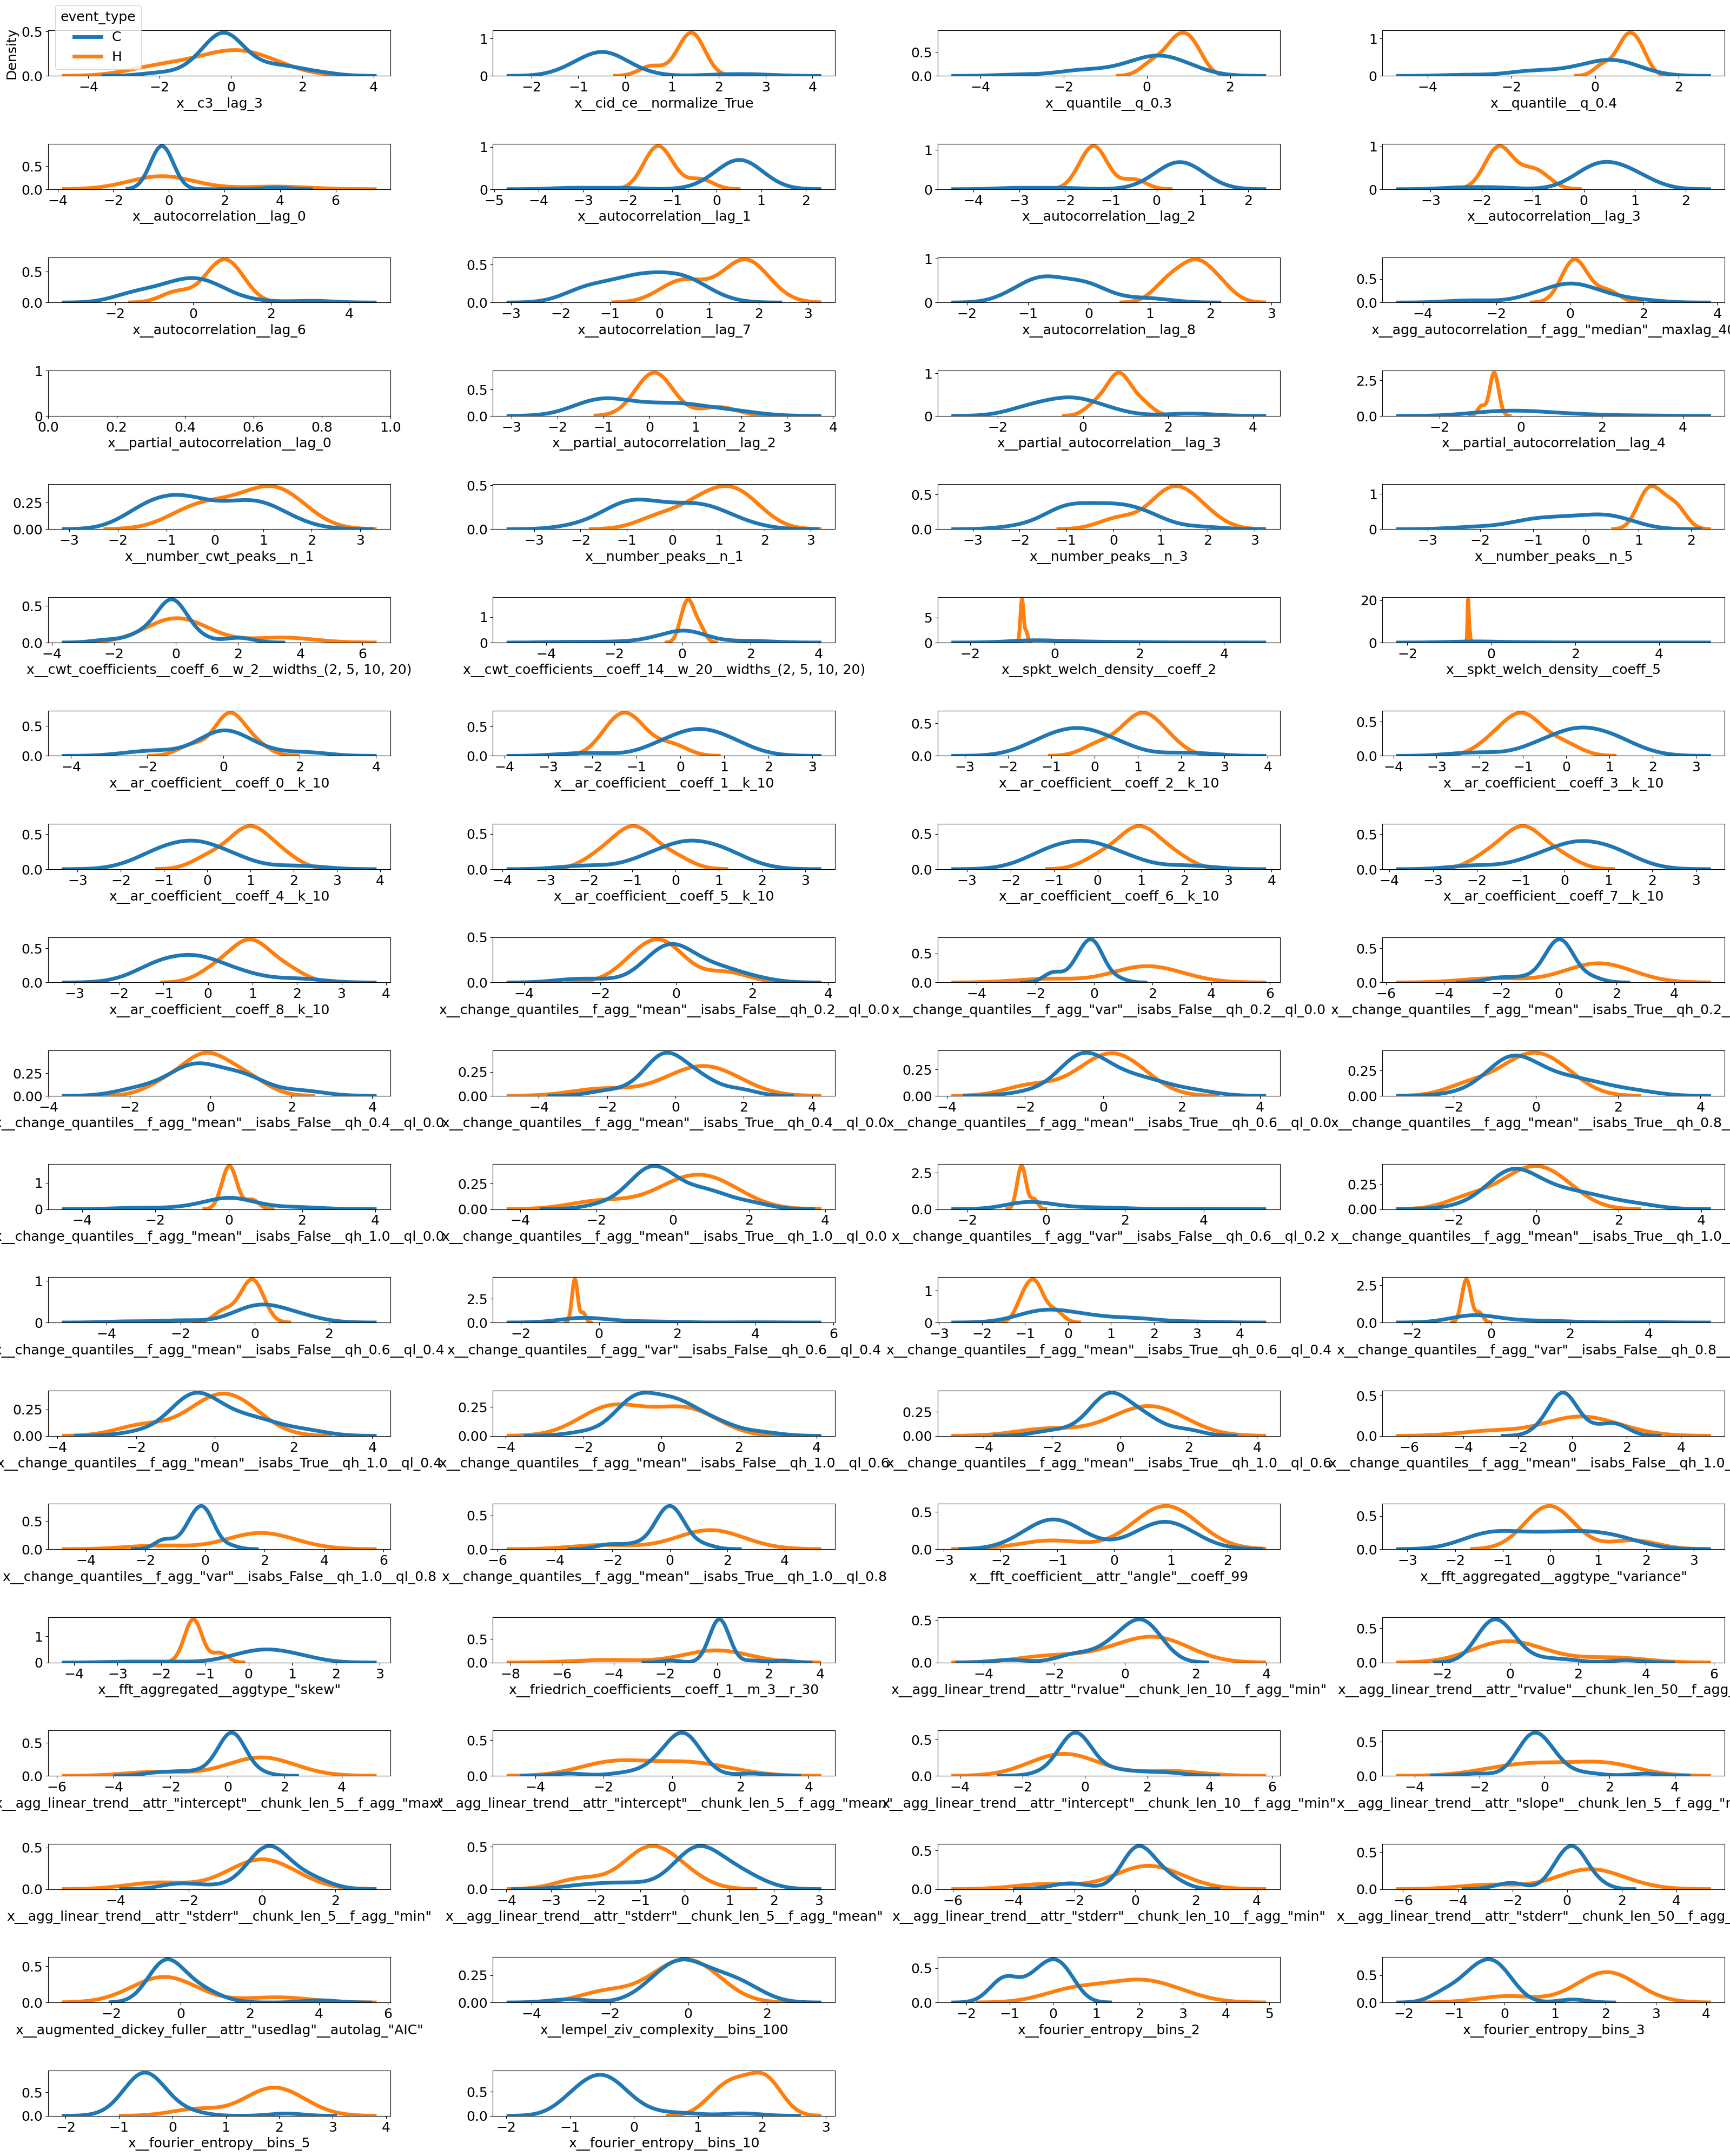

In [3]:
#Figure4 SI figure -- just all of the ones 
df = pd.read_csv('significant_features_test.csv')
df3 =  df.drop(labels='Unnamed: 0',axis=1)
# df2 = df2.drop(labels='x__autocorrelation__lag_0',axis=1)
# df2 = df2.drop(labels='x__partial_autocorrelation__lag_0',axis=1)
# df2 = df2.drop(labels='x__ar_coefficient__coeff_1__k_10', axis=1)
# df2 = df2.drop(labels='x__friedrich_coefficients__coeff_1__m_3__r_30',axis=1)
# df2 = df2.drop(labels='x__ar_coefficient__coeff_7__k_10', axis=1)
# df2 = df2.drop(labels='x__ar_coefficient__coeff_8__k_10', axis=1)



# df3 = df2.rename(columns={
   
#                         'x__skewness': 'skewness', 'x__kurtosis':'kurtosis', 'x__autocorrelation__lag_1':'autocorrelation with 1 sample \n lag',
                        
#                         'x__autocorrelation__lag_2':'autocorrelation with 2 sample lag', 'x__autocorrelation__lag_7':'autocorrelation with 7 sample \n lag',
                        
#                         'x__autocorrelation__lag_8':'autocorrelation with 8 sample lag', 'x__agg_autocorrelation__f_agg_"median"__maxlag_40':'median of all autocorrelations \n up to lag of 40 samples',
                       
#                         'x__agg_linear_trend__attr_"slope"__chunk_len_50__f_agg_"mean"':'mean of slope in each 50 \n sample bin',
            
#                         'x__ratio_beyond_r_sigma__r_1.5':'spikes --ratio of points  \n beyond 1.5* std',
            
#                         'x__ratio_beyond_r_sigma__r_7':'spikes --ratio of points  \n beyond 7* std',
    
#                         'x__fourier_entropy__bins_2':' sum of spectral entropy in \n 2 bins',
    
#                         'x__fourier_entropy__bins_3':' sum of spectral entropy in \n 3 bins',
    
                        # 'x__fourier_entropy__bins_10':' sum of spectral entropy in \n 10 bins',
                       
                        # 'x__fourier_entropy__bins_5':' sum of spectral entropy in \n 5 bins',
        
                        # 'x__partial_autocorrelation__lag_1':'partial autocorrealtion \n with 1 sample lag',
    
                        # 'x__partial_autocorrelation__lag_2':'partial autocorrealtion \n with 2 sample lag',
    
                        # 'x__partial_autocorrelation__lag_4':'partial autocorrealtion \n with 4 sample lag',
    
                        # 'x__number_peaks__n_50':'number of peaks seperated by \n 50 samples',
    
                        # 'x__cwt_coefficients__coeff_14__w_20__widths_(2, 5, 10, 20)':'Continuous wavelet transform \n coefficients',
            
                        # 'x__spkt_welch_density__coeff_5':'Welch’s power spectral \n density estimate',
    
                        # 'x__ar_coefficient__coeff_0__k_10':'maximum likelihood of an autoregressive \n process  with lag of 10 sample',
    
                        # 'x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"var"':'variance of linear trend in \n 10 sample chunks',
    
                        # 'x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max"':'maximum value of linear trend in \n 50 sample chunks',
    
                        # 'x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean"':'means value of linear trend in \n 50 sample chunks',
    
                       #  'x__fft_aggregated__aggtype_"variance"':'variance of the fourier spectrum',
    
                       #  'x__fft_aggregated__aggtype_"skew"':'skew of the fourier spectrum',
    
                       #  'x__c3__lag_3':'3rd order autocovariance',
    
                       #  'x__autocorrelation__lag_3':'autocorrelation with 3 sample lag',
    
                       #  'x__partial_autocorrelation__lag_5':'partial autocorrealtion \n with 5 sample lag',
    
                       #  'x__partial_autocorrelation__lag_6':'partial autocorrealtion \n with 6 sample lag',
    
                       #  'x__number_cwt_peaks__n_1':'number of peaks in \n smoothed timeseries',
    
                       #  'x__number_peaks__n_1':'number of peaks \n seperated by 1 sample',
    
                       #  'x__number_peaks__n_1':'number of peaks \n seperated by 3 samples',
    
                       #  'x__permutation_entropy__dimension_6__tau_1':'permutation entropy',
    
                       #  'x__augmented_dickey_fuller__attr_"usedlag"__autolag_"AIC"':'Augmented Dickey-Fuller test',
    
                       #  'x__fft_coefficient__attr_"angle"__coeff_99':'fft coefficient angle'
                       
                       # })
                         

plt.rcParams.update({'font.size': 18})

plt.figure(figsize=(40,80))

##plotting all of the significant features

plt.subplots_adjust(hspace=1.5, wspace=0.3)
ax_list = []
n=0
import matplotlib
for i,(columnName, columnData) in enumerate(df3.items()):
    if columnName == 'event_type': 
        continue
    if columnName == 'dist':
        continue
    if columnName == 'mag':
        continue
    print(columnName)
    ax = plt.subplot(30, 4, n + 1)
    ax = sns.kdeplot(data = df3, x = columnName,hue='event_type',common_norm=False,lw=5)
    if (n)/2!=int((n)/4):
        ax.set(ylabel=None)
        ax_list.append(ax)
    if n >= 1:
        ax.legend_.remove()
    n=n+1

# plt.savefig('fig4_tsfresh_figure1',dpi=700)